In [1]:
#Gerekli kütüphaneler
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score,StratifiedKFold
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score
from xgboost import XGBClassifier, plot_tree
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import math
#Modeller
import xgboost as xgb
import lightgbm as lgb
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier



Gerekli kütüphanelerimizi ve modellerimizi import ediyoruz

In [2]:
#  Veri Yükleme
df = pd.read_csv("heart_2020_cleaned.csv")
df = df.sample(n=100000, random_state=42)

Veri okumana işlemini gerçekleştiriyoruz.Burada veri setim büyük olduğu için 30000 satır limiti getirdim.


In [3]:
#  Label Encoding
#Binary  kategorik sütunlar listelendirdik
binary_columns = ['HeartDisease', 'Smoking', 'AlcoholDrinking', 'Stroke',
                  'DiffWalking', 'Sex', 'Diabetic', 'PhysicalActivity',
                  'Asthma', 'KidneyDisease', 'SkinCancer']

for col in binary_columns:#Kadın veya erkek değişkenleri 0 ve 1 ataması yaptım
    df[col] = df[col].map({'Yes': 1, 'No': 0, 'Male': 1, 'Female': 0})

multi_cat_columns = ['AgeCategory', 'Race', 'GenHealth']# Buradakiler birden fazla kategoriye sahip sütunları görütüleleyip listeye kaydettim
le = LabelEncoder()

for col in multi_cat_columns:# Yukarıdaki birden fazla katagoriye sahip olan sütünlar için  sayısal değerlere dönüştürdüm
    df[col] = le.fit_transform(df[col])

Veri setindeki kategorik sütunlar modelin anlayabileceği biçimde sayısal değerlere çevirdim
- Binary sütunları  Yes/No  1/0 diye tanımladım
- Çok kategorili sütunlar  `LabelEncoder` ile sayısallaştırdım

##  Nümerik EDA



In [4]:
#  Veri Setine İlk Bakış
print(df.head()) # İlk 5 satırını görüyoruz
print(df.info()) # Sütünların veri tiplerini ve 30000 satır 18 sütün olduğunu görüyoruz
print(df.describe(include='all')) #HeartDisease sütununa baktığımzıda %8.7 lik kalp rahatsızlığı olmaa durumu var

        HeartDisease    BMI  Smoking  AlcoholDrinking  Stroke  PhysicalHealth  \
118175             0  33.28        0                0       0             0.0   
86772              0  23.78        0                0       0             3.0   
37503              0  32.78        0                0       0             0.0   
19839              0  25.82        1                1       0             2.0   
67234              0  23.71        0                0       0             0.0   

        MentalHealth  DiffWalking  Sex  AgeCategory  Race  Diabetic  \
118175           7.0            0    0            1     2       0.0   
86772            0.0            1    0           12     5       NaN   
37503            0.0            0    1            9     5       0.0   
19839            0.0            0    0           10     5       0.0   
67234            2.0            0    1            5     1       0.0   

        PhysicalActivity  GenHealth  SleepTime  Asthma  KidneyDisease  \
118175       

Veri setinin genel özellikleri incelenmiştir:
- İlk 5 satır gösterdim
- Veri tipleri ve eksik değer olup olmadığını temel istatistikler ile gözlemledim.
-30000 satır 18 sütün olduğunu görüyoruz
-HeartDisease  ortalamaya baktığım da  %8.7 lik kalp rahatsızlığı olma durumu olduğunu görüyorum

##Histogramlar & Korelasyon

Veri setindeki sütunların dağılımını daha iyi anlayabilmek için histogramlar kullandım. Bu sayede hangi değişkenler dengeli, hangileri dengesiz kolayca görülebiliyor.Özellikler arasındaki ilişkileri görmek için de korelasyon matrisi oluşturdum.

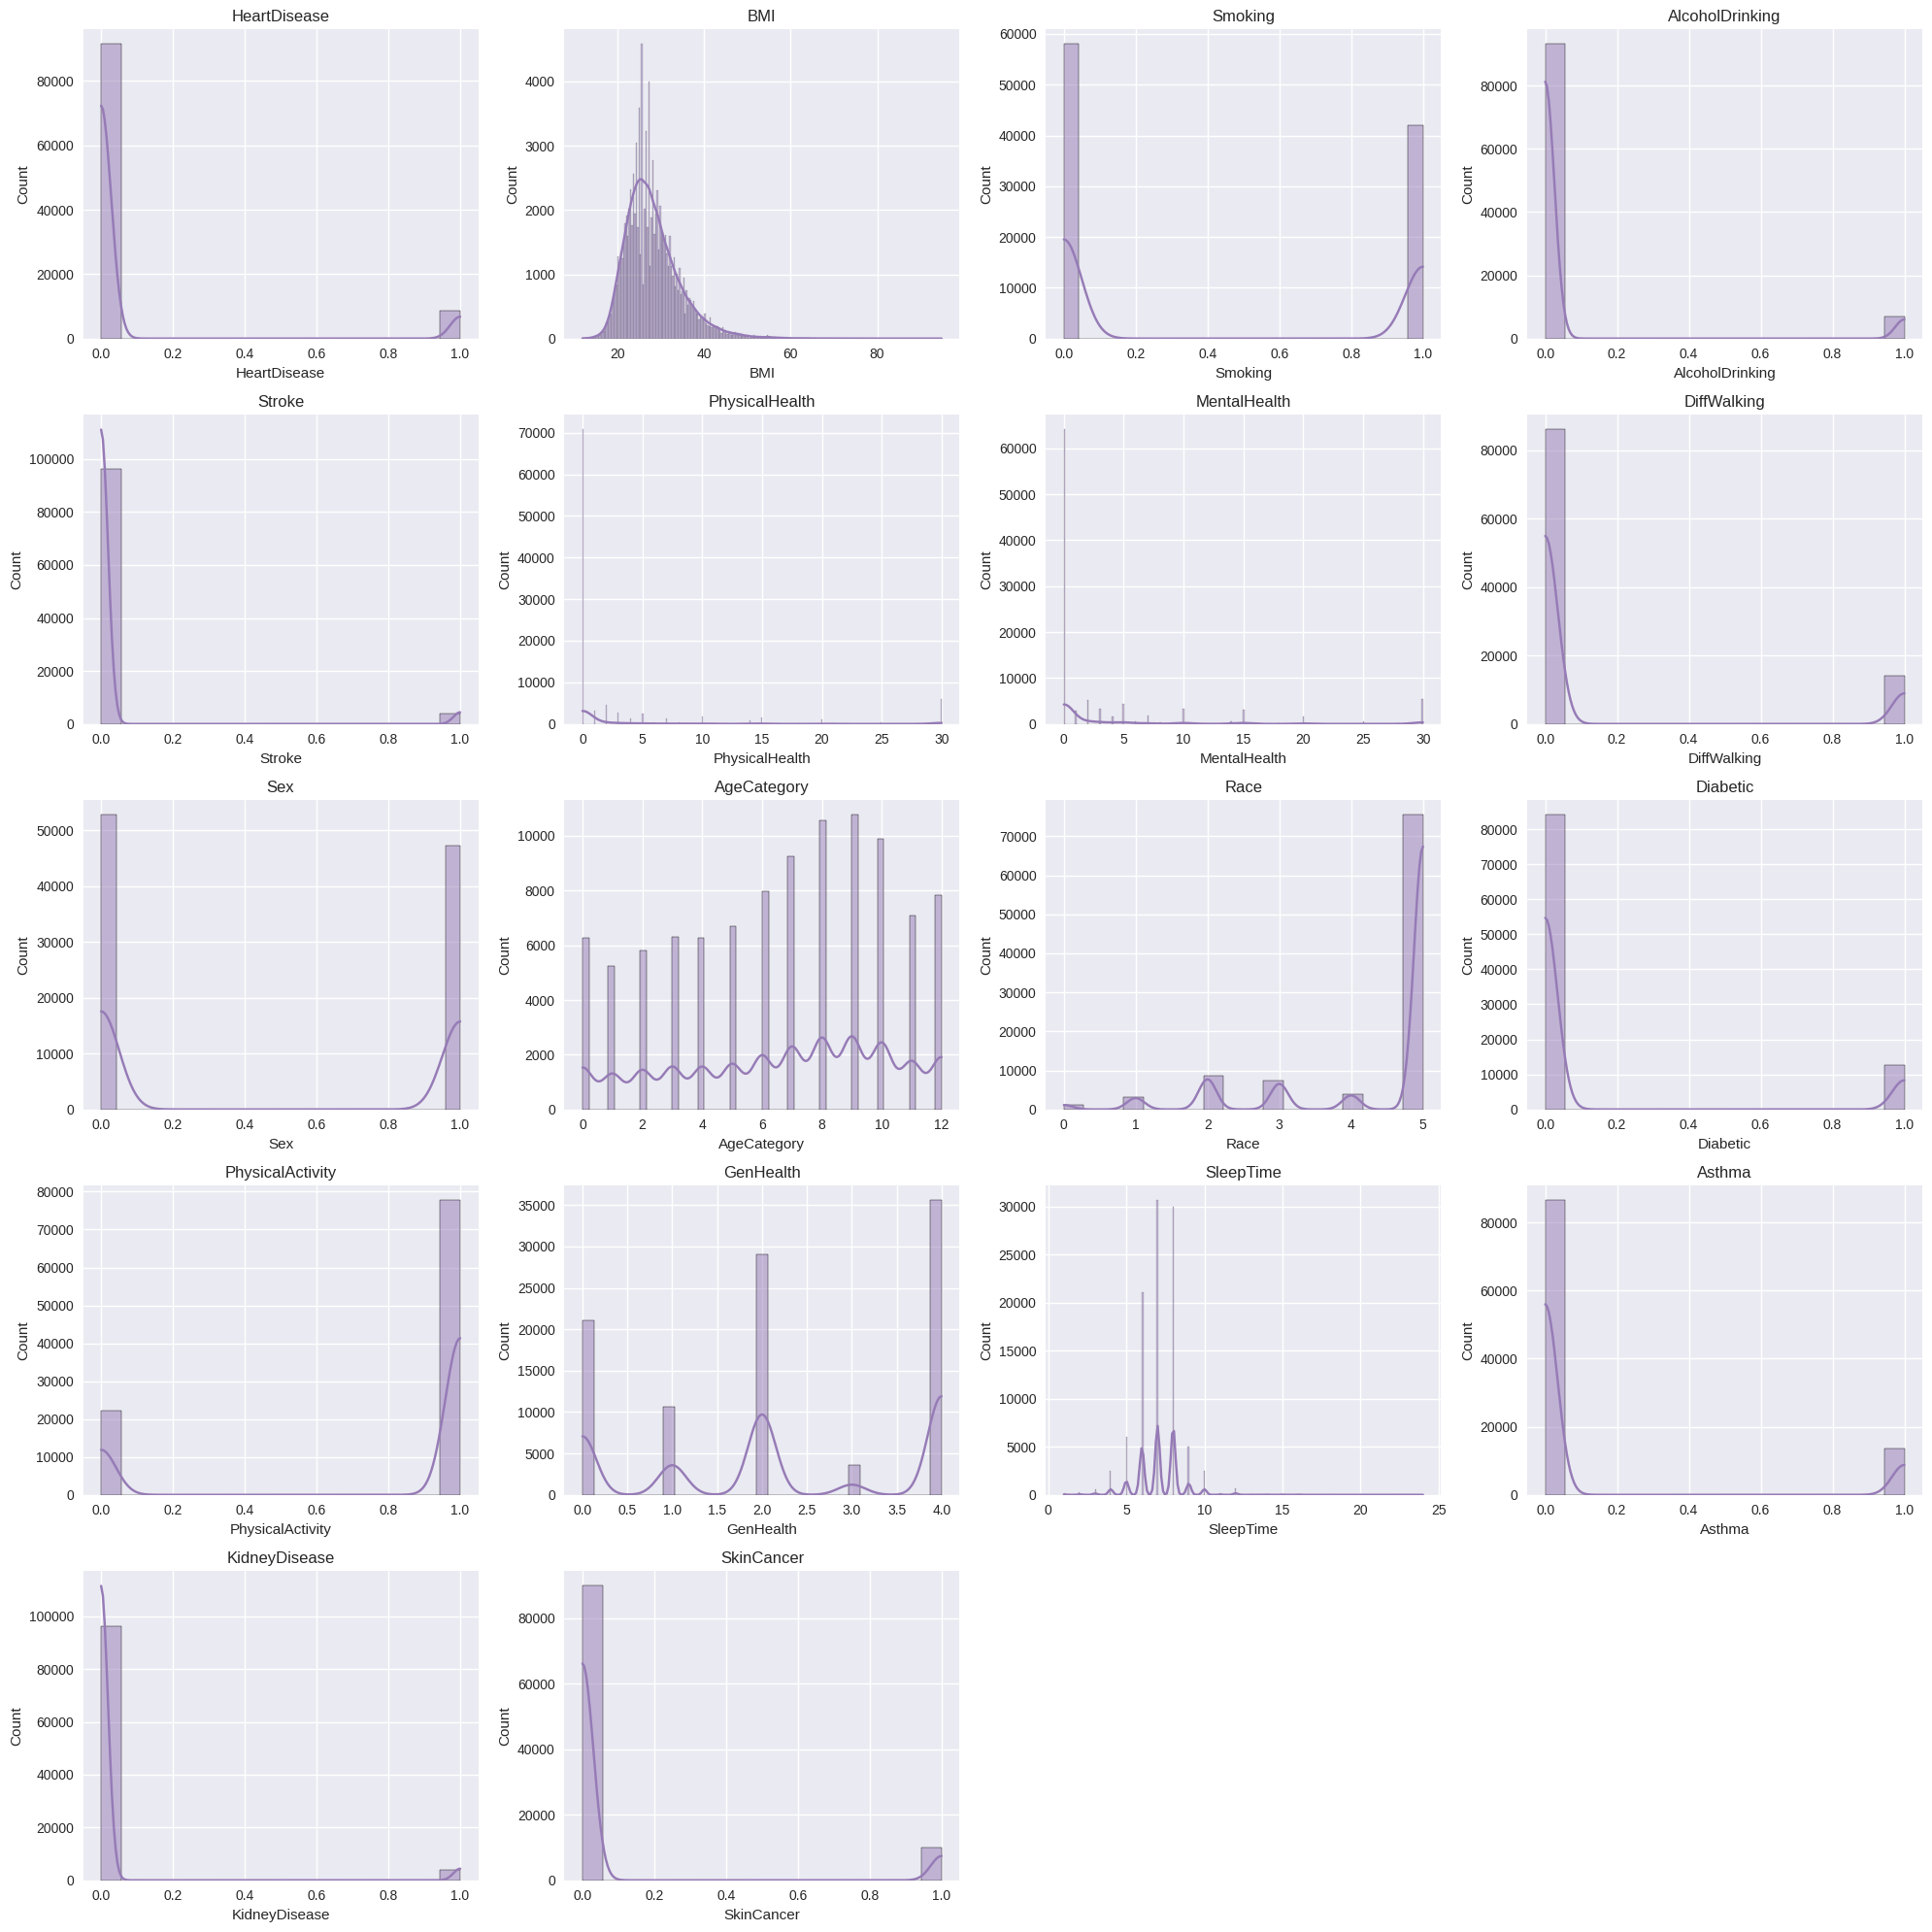

In [5]:
#Her özelliğin dağılımını görselleştirdim ve veri seti hakkında bilgi edindim.
plt.style.use('seaborn-v0_8')
num_cols = len(df.columns)
n_cols = 4
n_rows = math.ceil(num_cols / n_cols)
fig = plt.figure(figsize=(5 * n_cols, 4 * n_rows))
for index, column in enumerate(df.columns):
    plt.subplot(n_rows, n_cols, index + 1)
    sns.histplot(data=df, x=column, color='#967bb6', kde=True)
    plt.title(column, size=12)
    plt.grid(True)
fig.tight_layout()
plt.show()

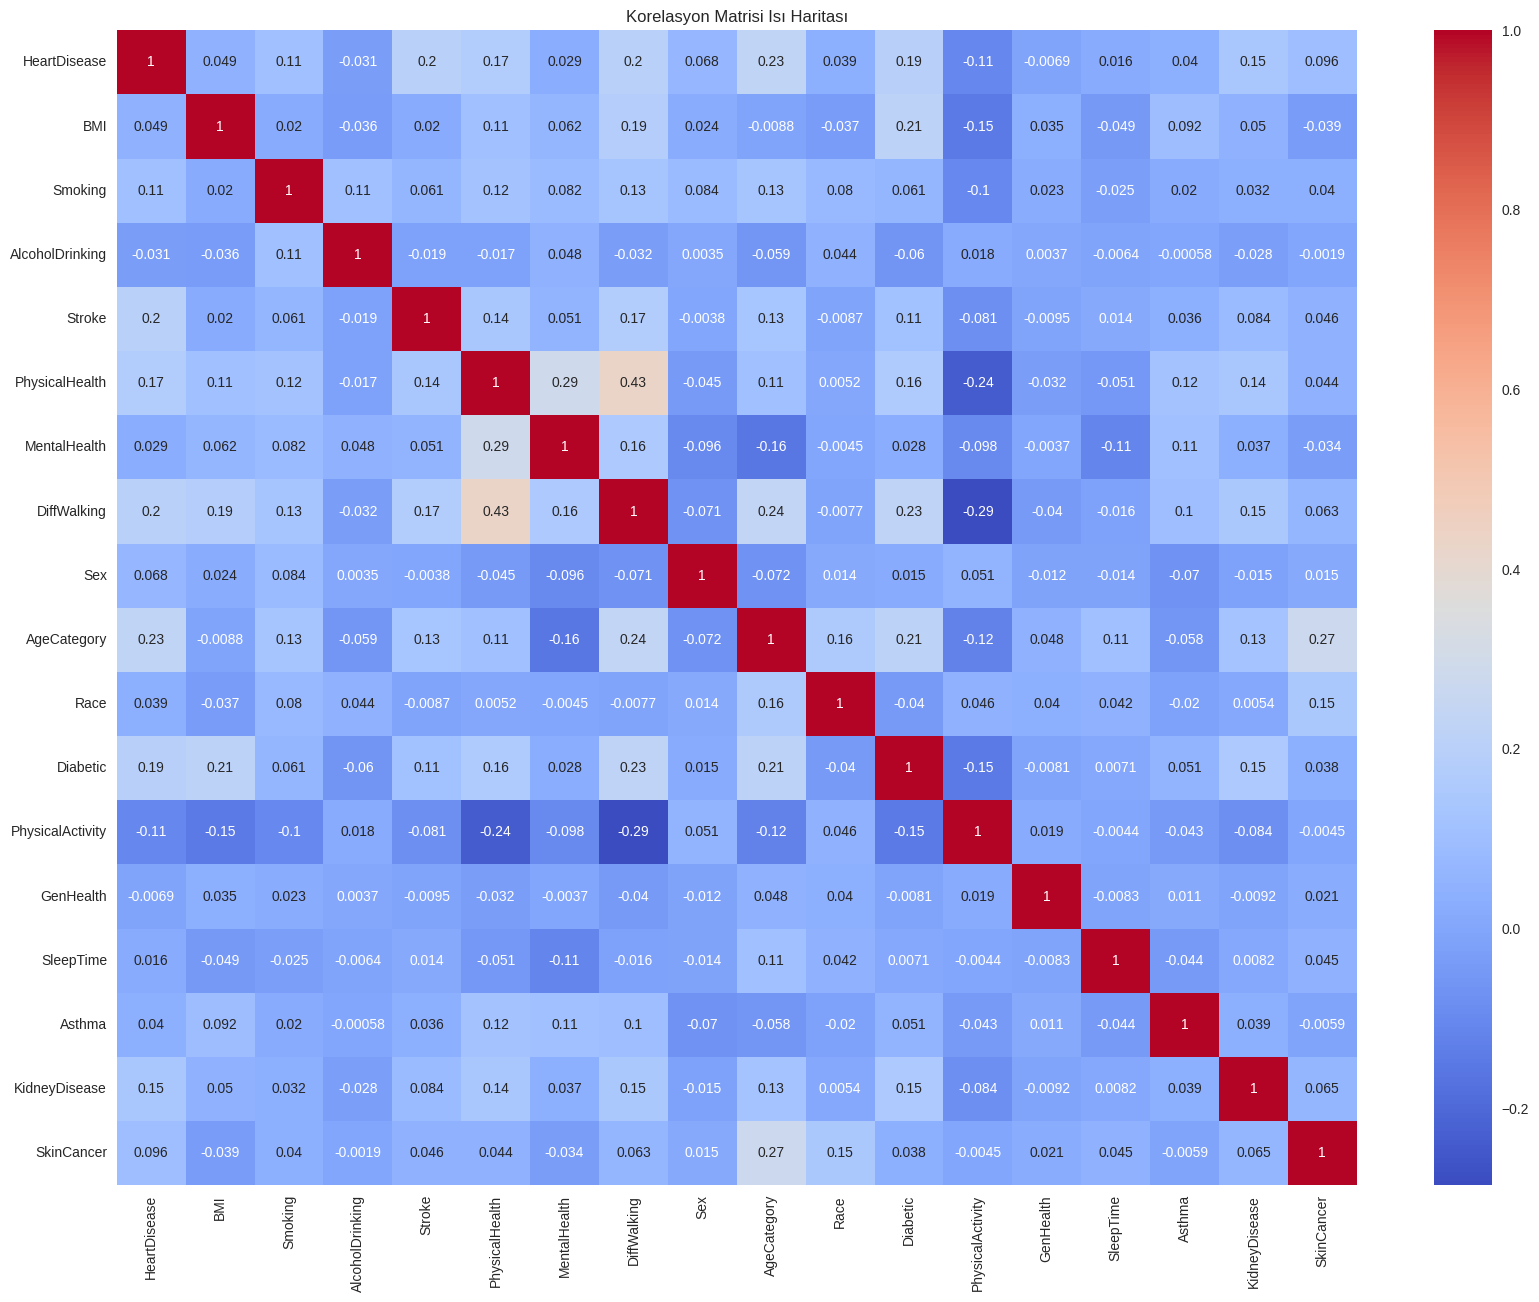

In [6]:
corr_matrix = df.corr()
plt.figure(figsize=(20, 15))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.title("Korelasyon Matrisi Isı Haritası")
plt.show()
#Burada veri setimizdeki tüm değişkenler arasındaki korelasyon ilişkilerini gösterir.
#Kırmızı tonları pozitif korelasyonu,mavi tonları negatif korelasyonu,beyaz veya açık renkler, korelasyonun sıfıra yakın olduğunu söyler
#Mesela smoking ile HeartDisease  de kırmızı oldupu için kalp hastalığı riskini arttır


##Özellik Önemleri

XGBoost modelinin öğrenme sürecinde hangi değişkenlere ne kadar önem verdiği analiz edilmiştir.

Text(0.5, 1.0, 'Hastalığın oluşmasındaki etmenlerin etkileri')

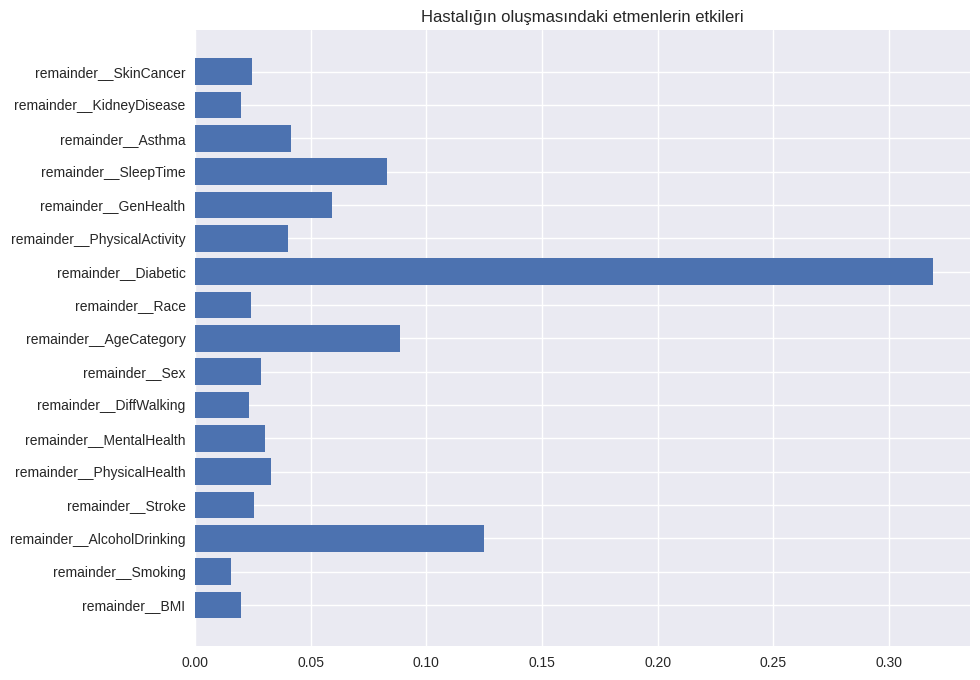

In [21]:
#Burada neyin kalp hastalığına etkisinin daha çok olduğunu görmemizi sağlıyor
feature_importance = best_xgb.feature_importances_
plt.figure(figsize=(10, 8))
plt.barh(feature_names, feature_importance)
plt.title('Hastalığın oluşmasındaki etmenlerin etkileri')

##Normalizasyon

Burada önce verideki sınıf dengesizliğini SMOTE  tekniği ile gidermeye çalıştım. SMOTE yalnızca sayısal verilerle çalıştığı için öncelikle kategorik değişkenlere One-Hot Encoding işlemi uyguladım. SMOTE sonrası veride hala işlenmemiş kategorik değişkenler olduğundan tüm işlem adımlarını Pipeline içerisine entegre ettim. Ayrıca modelin daha iyi çalışması için bazı hiperparametre ayarlarını Params kısmında denedim.

Ancak SMOTE uyguladıktan sonra model performansının düştüğünü gözlemledim. Özellikle XGBoost modelinde F1 skoru ve accuracy değerleri SMOTE uygulanmamış versiyona göre daha düşük çıktı.

Sonuç olarak SMOTE'u denedim ancak skorlarımı düşürdüğü için modelin son  halinde kullanmamayı tercih ettim. SMOTE’un her zaman faydalı olmadığını, model performansına göre değerlendirilerek dikkatli bir şekilde uygulanması gerektiğini görmüş oldum.

In [8]:
#  Bağımlı ve bağımsız değişkenleri ayırdım
X = df.drop(columns=["HeartDisease"])
y = df["HeartDisease"]

In [9]:
#  %20 eğitim için ayırıp %80 seni  eğitim için ayırdım
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [10]:
#  Pipeline ve Ön İşleme
categorical_cols = X.select_dtypes(include=['object']).columns
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ],
    remainder='passthrough'
)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(eval_metric='logloss'))
])
params = {
    'classifier__max_depth': [3, 6, 10],
    'classifier__learning_rate': [0.1, 0.2],
    'classifier__n_estimators': [100, 200],
    'classifier__scale_pos_weight': [1,5, 10, 15]
}


#Modellerin Karşılaştırılması


In [13]:
#  Tüm modellerle karşılaşılaştırıyoruz
models = [
    ('XGBoost', XGBClassifier(eval_metric='logloss')),
    ('Logistic Regression', LogisticRegression(max_iter=1000)),
    ('Support Vector Classifier', SVC()),
    ('Naive Bayes', GaussianNB()),
    ('KNN', KNeighborsClassifier()),
    ('Decision Tree', DecisionTreeClassifier()),
    ('AdaBoost', AdaBoostClassifier()),
    ('Gradient Boosting', GradientBoostingClassifier())
]

results = []
confusion_matrices = []
classification_reports = []

for model_name, model in models:
    pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    cv_score = cross_val_score(pipe,  X_train, y_train, cv=5).mean()
    cm = confusion_matrix(y_test, y_pred)
    cr = classification_report(y_test, y_pred)
    results.append((model_name, cv_score, accuracy))
    confusion_matrices.append((model_name, cm))
    classification_reports.append((model_name, cr))

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [14]:
# Sonuçların Görselleştirilmesi
import pandas as pd
df_results = pd.DataFrame(results, columns=['Model', 'Cross-Validation Accuracy', 'Test Accuracy'])
df_results.sort_values('Cross-Validation Accuracy', ascending=False, inplace=True)
print(df_results.to_string(index=False))

                    Model  Cross-Validation Accuracy  Test Accuracy
        Gradient Boosting                   0.915500        0.91420
                 AdaBoost                   0.914813        0.91305
Support Vector Classifier                   0.914362        0.91315
      Logistic Regression                   0.914212        0.91420
                  XGBoost                   0.912850        0.91170
                      KNN                   0.907200        0.90400
            Decision Tree                   0.863638        0.86095
              Naive Bayes                   0.846263        0.84070


In [15]:

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_grid_önce_smote = GridSearchCV(pipeline, param_grid=params, cv=cv, scoring='f1')
cv_grid_önce_smote.fit(X_train, y_train) # SMOTE uygulanmamış eğitim verisi

print("SMOTE öncesi test set skoru: %.2f" % cv_grid_önce_smote.score(X_test, y_test))
print("SMOTE öncesi en iyi parametreler:", cv_grid_önce_smote.best_params_)

# SMOTE öncesi modelin test verisindeki tahminlerini alıp raporu görmek için
y_pred_önce_smote = cv_grid_önce_smote.predict(X_test)
print("SMOTE öncesi sınıflandırma raporu:")
print(classification_report(y_test, y_pred_önce_smote))


SMOTE öncesi test set skoru: 0.38
SMOTE öncesi en iyi parametreler: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__n_estimators': 100, 'classifier__scale_pos_weight': 5}
SMOTE öncesi sınıflandırma raporu:
              precision    recall  f1-score   support

           0       0.96      0.86      0.91     18263
           1       0.29      0.57      0.38      1737

    accuracy                           0.84     20000
   macro avg       0.62      0.72      0.64     20000
weighted avg       0.90      0.84      0.86     20000



In [16]:
#Burada SMOTE NaN  değerler ile bir sonuç vermediği için varsa boş verileri  doldurdum

for col in X_train.columns:
    if X_train[col].dtype in ['float64', 'int64']:
        mean_val = X_train[col].mean()
        X_train[col] = X_train[col].fillna(mean_val)
        X_test[col] = X_test[col].fillna(mean_val)
    else:
        mode_val = X_train[col].mode()[0]
        X_train[col] = X_train[col].fillna(mode_val)
        X_test[col] = X_test[col].fillna(mode_val)


In [17]:

#  SMOTE ile sınıf dengesini sağladım
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

In [18]:
print(pd.Series(y_train_res).value_counts())


HeartDisease
1    73149
0    73149
Name: count, dtype: int64


In [19]:
#  SMOTElu halidir.
cv_grid = GridSearchCV(pipeline, param_grid=params, cv=5,scoring='f1')
cv_grid.fit(X_train_res, y_train_res)

print("Test set skoru: %.2f" % cv_grid.score(X_test, y_test))
print("En iyi parametreler:", cv_grid.best_params_)
y_pred = cv_grid.predict(X_test)
print(classification_report(y_test, y_pred))

Test set skoru: 0.26
En iyi parametreler: {'classifier__learning_rate': 0.2, 'classifier__max_depth': 10, 'classifier__n_estimators': 200, 'classifier__scale_pos_weight': 1}
              precision    recall  f1-score   support

           0       0.93      0.93      0.93     18263
           1       0.26      0.27      0.26      1737

    accuracy                           0.87     20000
   macro avg       0.59      0.60      0.60     20000
weighted avg       0.87      0.87      0.87     20000



##XGBoost Ağacını Görselleştirme

Parametrelerle eğitilen XGBoost modeline ait ilk karar ağacını göstermektedir. Bu ağaç yapısı modelin tahmin yaparken nasıl bir yol izlediğini ve hangi özelliklere göre karar verdiğini görsel olarak sunar. Özellikle karar verme süreçlerini anlamak modelin şeffaflığını artırır ve yorumlanabilirliğini kolaylaştırır.

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.359705 to fit


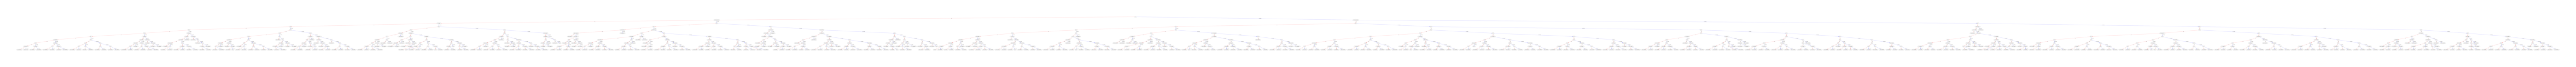

In [20]:

best_xgb = cv_grid.best_estimator_.named_steps['classifier']
feature_names = cv_grid.best_estimator_.named_steps['preprocessor'].get_feature_names_out()
fig, ax = plt.subplots(figsize=(20, 10), dpi=300)
plot_tree(best_xgb, num_trees=0, ax=ax, feature_names=feature_names)
plt.show()